In [46]:
import os
from langchain_community.document_loaders import DirectoryLoader, UnstructuredMarkdownLoader

loader = DirectoryLoader(
    './k8s_data/concepts', 
    glob="**/*.md", 
    loader_cls=UnstructuredMarkdownLoader
)

raw_docs = loader.load()
print(f"Loaded {len(raw_docs)} documents.")
# find . | grep .md | wc -l -> 163 docs

Loaded 163 documents.


In [47]:
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from langchain_core.documents import Document

In [48]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [49]:
raw_docs[0].metadata

{'source': 'k8s_data/concepts/_index.md'}

In [ ]:
def create_semantic_chunks(docs, percentile_threshold=95):
    """
    Takes a list of LangChain Document objects and splits them 
    into semantic chunks based on topic shifts.
    """
    all_chunks = []
    # distances are used for visualization
    all_distances = [] 
    
    for doc in docs:
        text = doc.page_content 
        metadata = doc.metadata
        
        sentences = re.split(r'(?<=[.?!])\s+|\n+', text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]
        
        if len(sentences) < 2:
            all_chunks.append(doc)
            continue

        embeddings = model.encode(sentences)
        distances = []
        for i in range(len(embeddings) - 1):
            sim = cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
            # use distance as 1 - similarity
            distances.append(1 - sim)
        
        all_distances.extend(distances) 

		# use percentile to determine breakpoints, if distance exceeds this then split into new chunk
        breakpoint_thresh = np.percentile(distances, percentile_threshold)
        
        current_chunk_sentences = [sentences[0]]
        for i, distance in enumerate(distances):
            if distance > breakpoint_thresh:
                all_chunks.append(Document(
                    page_content=" ".join(current_chunk_sentences),
                    metadata=metadata
                ))
                current_chunk_sentences = [sentences[i + 1]]
            else:
                current_chunk_sentences.append(sentences[i + 1])
        
        # final chunk
        all_chunks.append(Document(
            page_content=" ".join(current_chunk_sentences),
            metadata=metadata
        ))
        
    return all_chunks, all_distances, breakpoint_thresh

# semantic_docs, last_dist, last_thresh = create_semantic_chunks(raw_docs[:10])
semantic_docs, last_dist, last_thresh = create_semantic_chunks(raw_docs)

print(f"Docs split into {len(semantic_docs)} semantic segments.")

Success! Original 10 docs split into 1187 semantic segments.


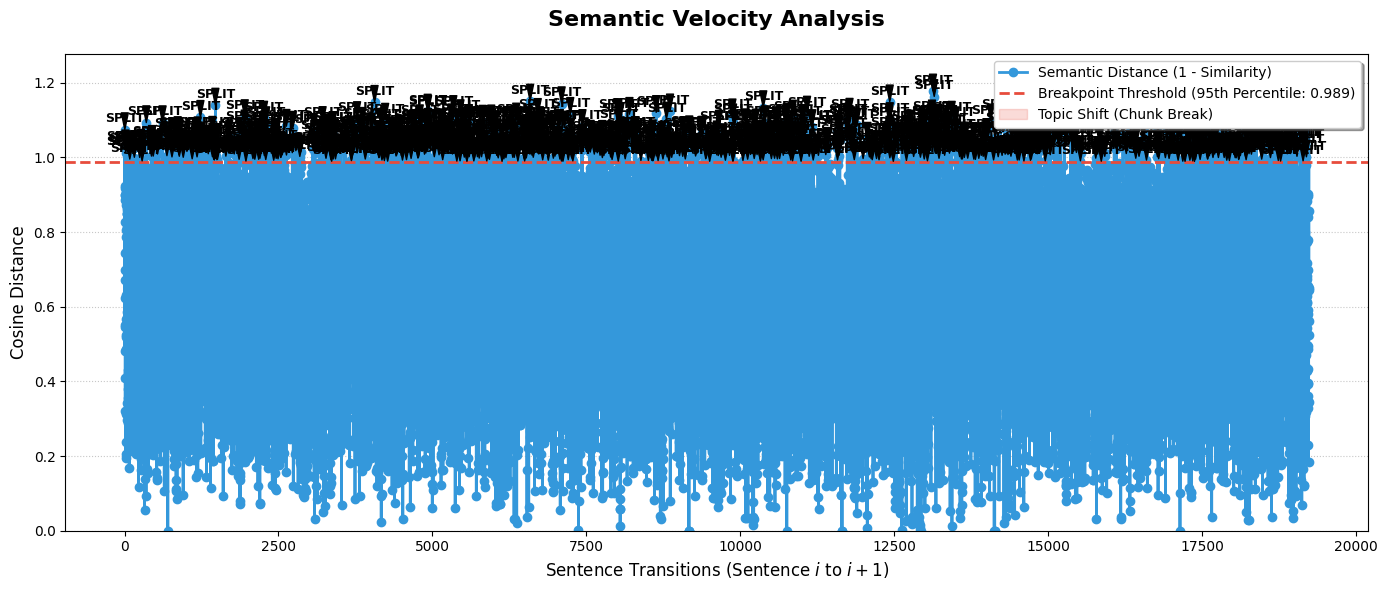

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# this can be visualized with raw_docs[:10] or something, otherwise it is too crowded. Even in the case with 10 it is still a lot of chunks.
def visualize_semantic_jumps(distances, threshold):
    plt.style.use('seaborn-v0_8-muted')
    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(distances))
    ax.plot(x, distances, marker='o', linestyle='-', color='#3498db', 
            linewidth=2, markersize=6, label='Semantic Distance (1 - Similarity)')

    ax.axhline(y=threshold, color='#e74c3c', linestyle='--', linewidth=2, 
               label=f'Breakpoint Threshold (95th Percentile: {threshold:.3f})')

    ax.fill_between(x, distances, threshold, where=(np.array(distances) > threshold),
                    color='#e74c3c', alpha=0.2, interpolate=True, label='Topic Shift (Chunk Break)')

    for i, dist in enumerate(distances):
        if dist > threshold:
            ax.annotate('SPLIT', xy=(i, dist), xytext=(i, dist + 0.02),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                        fontsize=9, fontweight='bold', ha='center')

    ax.set_title("Semantic Velocity Analysis", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel("Sentence Transitions (Sentence $i$ to $i+1$)", fontsize=12)
    ax.set_ylabel("Cosine Distance", fontsize=12)
    ax.set_ylim(0, max(distances) + 0.1)
    ax.legend(loc='upper right', frameon=True, shadow=True)
    ax.grid(axis='y', linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

visualize_semantic_jumps(last_dist, last_thresh)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever

hf_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Semantic Search
vector_db = FAISS.from_documents(
    documents=semantic_docs,
    embedding=hf_embeddings,
)

vector_retriever = vector_db.as_retriever(search_kwargs={"k": 25})

# Keyword Search
bm25_retriever = BM25Retriever.from_documents(documents=semantic_docs)
bm25_retriever.k = 25

In [ ]:
def rrf(vector_results, bm25_results, k=60):
    """
    Implements a Reciprocal Rank Fusion.
    k is smoothing constant. Standard is 60.
    RRF = sum(1 / (k + rank))
    """
    
    rrf_scores = {}
    for rank, doc in enumerate(vector_results, start=1):
        doc_id = doc.page_content
        rrf_scores[doc_id] = rrf_scores.get(doc_id, 0) + (1 / (k + rank))

    for rank, doc in enumerate(bm25_results, start=1):
        doc_id = doc.page_content
        rrf_scores[doc_id] = rrf_scores.get(doc_id, 0) + (1 / (k + rank))
        
    sorted_content = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    all_docs = {d.page_content: d for d in vector_results + bm25_results}
    fused_docs = [all_docs[content] for content, score in sorted_content]
    
    return fused_docs

# Test query
query = "How to configure resource limits for a Pod?"
v_docs = vector_retriever.invoke(query)
b_docs = bm25_retriever.invoke(query)

fused_results = rrf(v_docs, b_docs)
print("Query:", query)
print(f"Fused {len(fused_results)} unique documents using RRF.")
print(f"Top Fused Doc Excerpt: {fused_results[0].page_content}...")

Query: How to configure resource limits for a Pod?
Fused 43 unique documents using RRF.
Top Fused Doc Excerpt: Pod resources example {#example-2} {{< feature-state feature_gate_name="PodLevelResources" >}} This feature can be enabled by setting the PodLevelResources feature gate. The following Pod has an explicit request of 1 CPU and 100 MiB of memory, and an explicit limit of 1 CPU and 200 MiB of memory. The pod-resources-demo-ctr-1 container has explicit requests and limits set. However, the pod-resources-demo-ctr-2 container will simply share the resources available within the Pod resource boundaries, as it does not have explicit requests and limits set. {{% code_sample file="pods/resource/pod-level-resources.yaml" %}} How Pods with resource requests are scheduled When you create a Pod, the Kubernetes scheduler selects a node for the Pod to run on. Each node has a maximum capacity for each of the resource types: the amount of CPU and memory it can provide for Pods. The scheduler ens

In [ ]:
from sentence_transformers import CrossEncoder

# NOTE: change to "cpu" or "cuda" if not on MAC
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='mps')
# cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')

def hf_rerank(query, fused_docs, top_n=5):
    pairs = [[query, doc.page_content] for doc in fused_docs]
    scores = cross_encoder_model.predict(pairs)
    
    # Sort by score
    scored_docs = sorted(zip(scores, fused_docs), key=lambda x: x[0], reverse=True)
    print(f"Top Re-ranking Score: {scored_docs[0][0]:.4f}")
    return [doc for score, doc in scored_docs[:top_n]]

top_docs = hf_rerank(query, fused_results)
print(f"Top Re-ranked Doc Excerpt: {top_docs[0].page_content}")


Top Re-ranking Score: 6.0709
Top Re-ranked Doc Excerpt: {{< /note >}} You can configure a kubelet to limit the number of PIDs a given Pod can consume. For example, if your node's host OS is set to use a maximum of 262144 PIDs and expect to host less than 250 Pods, one can give each Pod a budget of 1000 PIDs to prevent using up that node's overall number of available PIDs. If the admin wants to overcommit PIDs similar to CPU or memory, they may do so as well with some additional risks. Either way, a single Pod will not be able to bring the whole machine down. This kind of resource limiting helps to prevent simple fork bombs from affecting operation of an entire cluster. Per-Pod PID limiting allows administrators to protect one Pod from another, but does not ensure that all Pods scheduled onto that host are unable to impact the node overall. Per-Pod limiting also does not protect the node agents themselves from PID exhaustion. You can also reserve an amount of PIDs for node overhead, sep

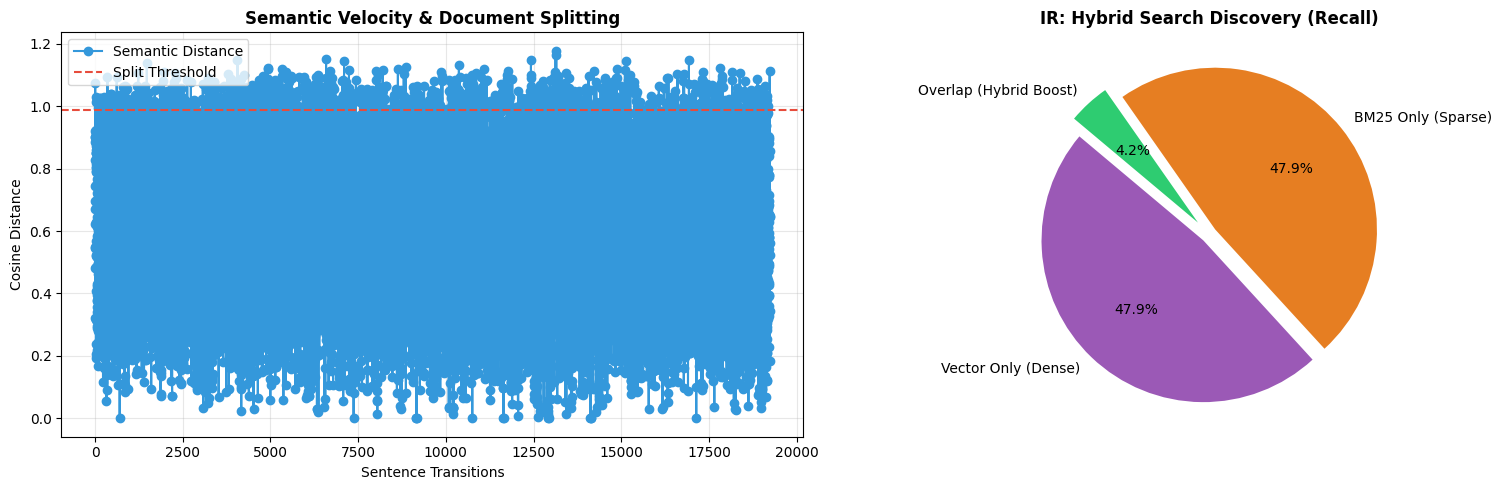

Top Re-ranking Score: 4.4924

--- Top 5 Reasoning Engine Results: 'What is a headless service and when should I use it?' ---


,Rank,Source Document,Content Snippet
0,1,k8s_data/concepts/services-networking/service.md,"Headless Services Sometimes you don't need load-balancing and a single Service IP. In this case, you can create what are termed headless Services, by explicitly specifying ""None"" for the cluster IP address (.spec.clusterIP). You can use a headless Service to interface with other service discovery mechanisms, without being tied to Kubernetes' implementation. For headless Services, a cluster IP is not allocated, kube-proxy does not handle these Services, and there is no load balancing or proxying ..."
1,2,k8s_data/concepts/overview/working-with-objects/common-labels.md,A Simple Stateless Service Consider the case for a simple stateless service deployed using Deployment and Service objects. The following two snippets represent how the labels could be used in their simplest form. The Deployment is used to oversee the pods running the application itself. apiVersion: apps/v1 kind: Deployment app.kubernetes.io/name: myservice app.kubernetes.io/instance: myservice-abcxyz The Service is used to expose the application. apiVersion: v1 kind: Service app.kubernetes.io/na...
2,3,k8s_data/concepts/workloads/controllers/statefulset.md,"StatefulSet is the workload API object used to manage stateful applications. {{< glossary_definition term_id=""statefulset"" length=""all"" >}} Using StatefulSets StatefulSets are valuable for applications that require one or more of the following: Stable, unique network identifiers. Stable, persistent storage. Ordered, graceful deployment and scaling. Ordered, automated rolling updates. In the above, stable is synonymous with persistence across Pod (re)scheduling. If an application doesn't require ..."
3,4,k8s_data/concepts/workloads/controllers/daemonset.md,"You can add your own tolerations to the Pods of a DaemonSet as well, by defining these in the Pod template of the DaemonSet. Because the DaemonSet controller sets the node.kubernetes.io/unschedulable:NoSchedule toleration automatically, Kubernetes can run DaemonSet Pods on nodes that are marked as unschedulable. If you use a DaemonSet to provide an important node-level function, such as cluster networking, it is helpful that Kubernetes places DaemonSet Pods on nodes before they are ready. For ex..."
4,5,k8s_data/concepts/services-networking/service.md,"content_type: concept weight: 10 {{< glossary_definition term_id=""service"" length=""short"" prepend=""In Kubernetes, a Service is"" >}} A key aim of Services in Kubernetes is that you don't need to modify your existing application to use an unfamiliar service discovery mechanism. You can run code in Pods, whether this is a code designed for a cloud-native world, or an older app you've containerized. You use a Service to make that set of Pods available on the network so that clients can interact with..."


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_custom_funnel(query, vector_retriever, bm25_retriever, last_distances, last_threshold):
    # --- Semantic Distance ---
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(last_distances, marker='o', linestyle='-', color='#3498db', label='Semantic Distance')
    plt.axhline(y=last_threshold, color='#e74c3c', linestyle='--', label='Split Threshold')
    plt.title("Semantic Velocity & Document Splitting", fontweight='bold')
    plt.ylabel("Cosine Distance")
    plt.xlabel("Sentence Transitions")
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Manual Hybrid Overlap ---
    # Get raw results from your manual retrievers
    v_results = vector_retriever.invoke(query)
    b_results = bm25_retriever.invoke(query)
    
    v_set = {d.page_content[:50] for d in v_results}
    b_set = {d.page_content[:50] for d in b_results}
    overlap = v_set.intersection(b_set)
    
    plt.subplot(1, 2, 2)
    labels = ['Vector Only (Dense)', 'BM25 Only (Sparse)', 'Overlap (Hybrid Boost)']
    sizes = [len(v_set - overlap), len(b_set - overlap), len(overlap)]
    colors = ['#9b59b6', '#e67e22', '#2ecc71']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=(0.05, 0.05, 0.1))
    plt.title("IR: Hybrid Search Discovery (Recall)", fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # --- The Funnel: Manual Fusion -> Re-Ranking ---
    fused_docs = rrf(v_results, b_results) 
    top_docs = hf_rerank(query, fused_docs)
    
    print(f"\n--- Top 5 Reasoning Engine Results: '{query}' ---")
    
    data = []
    for i, doc in enumerate(top_docs):
        source = doc.metadata.get('source', 'Unknown')
        snippet = doc.page_content[:500].replace('\n', ' ') + "..."
        data.append([i+1, source, snippet])
    
    df_results = pd.DataFrame(data, columns=['Rank', 'Source Document', 'Content Snippet'])
    
    display(df_results.style.set_properties(**{'text-align': 'left'}).set_table_styles([
        dict(selector='th', props=[('background-color', '#2c3e50'), ('color', 'white')])
    ]))

test_query = "What is a headless service and when should I use it?"
visualize_custom_funnel(test_query, vector_retriever, bm25_retriever, last_dist, last_thresh)